### Problem Statement
You are working for an airline company looking to enter the United States domestic market.
Specifically, the company has decided to start with 5 round trip routes between medium and
large US airports. An example of a round trip route is the combination of JFK to ORD and ORD
to JFK. The airline company has to acquire 5 new airplanes (one per round trip route) and the
upfront cost for each airplane is $90 million. The company's motto is "On time, for you", so
punctuality is a big part of its brand image.
 
You have been tasked with analyzing 1Q2019 data to identify:
1. The 10 busiest round trip routes in terms of number of round trip flights in the quarter.
Exclude canceled flights when performing the calculation.
2. The 10 most profitable round trip routes (without considering the upfront airplane cost) in
the quarter. Along with the profit, show total revenue, total cost, summary values of
other key components and total round trip flights in the quarter for the top 10 most
profitable routes. Exclude canceled flights from these calculations.
3. The 5 round trip routes that you recommend to invest in based on any factors that you
choose.
4. The number of round trip flights it will take to breakeven on the upfront airplane cost for
each of the 5 round trip routes that you recommend. Print key summary components for
these routes.
5. Key Performance Indicators (KPI's) that you recommend tracking in the future to
measure the success of the round trip routes that you recommend.

Here is background information on the three datasets that you will analyze:
1. Flights dataset: Contains data about available routes from origin to destination. For
occupancy, use the data provided in this dataset.
2. Tickets dataset: Ticket prices data (sample data only as the data is huge). Consider
only round trips in your analysis.
3. Airport Codes dataset: Identifies whether an airport is considered medium or large
sized. Consider only medium and large airports in your analysis.
Please do not use any data other than what has been provided to you.
When joining these datasets together, use your best judgment on the join condition and
document your choice.
Again, keep in mind that these are real-world datasets that come with outliers and data issues
that you need to address.

You can make the following assumptions:

● Each airplane is dedicated to one round trip route between the 2 airports

● Costs:

○ Fuel, Oil, Maintenance, Crew - $8 per mile total

○ Depreciation, Insurance, Other - \$1.18 per mile total

○ Airport operational costs for the right to use the airports and related services are fixed at 5,000 dollars for medium airports and $10,000 for large airports. There is one charge for each airport where a flight lands. Thus, a round trip flight has a total of
two airport charges.

○ For each individual departure, the first 15 minutes of delays are free, otherwise each minute costs the airline $75 in added operational costs.

○ For each individual arrival, the first 15 minutes of delays are free, otherwise each minute costs the airline $75 in added operational costs.

● Revenue:

○ Each plane can accommodate up to 200 passengers and each flight has an associated occupancy rate provided in the Flights data set. Do not use the Tickets data set to determine occupancy.

○ Baggage fee is 35 dollars for each checked bag per flight. We expect 50\% of passengers to check an average of 1 bag per flight. The fee is charged separately for each leg of a round trip flight, thus 50\% of passengers will be charged a total of 70 dollars in baggage fees for a round trip flight.

○ Disregard seasonal effects on ticket prices (i.e. ticket prices are the same in April as they are on Memorial Day or in December)

In [1]:
# import packages
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import matplotlib.pyplot as plt
pd.set_option("display.precision", 2)

In [2]:
# import data
url = "https://github.com/CapitalOneRecruiting/DA-Airline-Data-Challenge/blob/main/data.zip?raw=true"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
airport_data = pd.read_csv(z.open('Airport_Codes.csv'))
flight_data = pd.read_csv(z.open('Flights.csv'), low_memory=False)
ticket_data = pd.read_csv(z.open('Tickets.csv'))

In [3]:
airport_data.sample(5)

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
26565,small_airport,Blosser Municipal Airport,1486.0,NaN,US,Concordia,CNK,"-97.6522979736, 39.549301147499996"
2389,heliport,Clayton Heliport,261.0,NaN,US,Blythe,NaN,"-114.6449966430664, 33.60390090942383"
47939,small_airport,Reb Folbre's Place Airport,940.0,NaN,US,Millsap,NaN,"-97.9728012084961, 32.76259994506836"
49315,heliport,Juniper Hills Airport,4120.0,NaN,US,Bonanza,NaN,"-121.4580002, 42.1242981"
31043,large_airport,Santiago de Compostela Airport,1213.0,EU,ES,Santiago de Compostela,SCQ,"-8.415140151977539, 42.89630126953125"


In [4]:
flight_data.sample(5)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
1904546,2019-01-24,UA,N75851,478,11292,DEN,"Denver, CO",13930,ORD,"Chicago, IL",0.0,6.0,0.0,114.0,888.0,0.94
1403230,2019-01-29,WN,N7817J,2096,13232,MDW,"Chicago, IL",11292,DEN,"Denver, CO",NaN,NaN,1.0,NaN,895.0,0.84
1788862,2019-01-11,WN,N901WN,398,11278,DCA,"Washington, DC",10397,ATL,"Atlanta, GA",-6.0,-23.0,0.0,87.0,547.0,0.39
319754,2019-03-12,AS,N260AK,27,13930,ORD,"Chicago, IL",14747,SEA,"Seattle, WA",-8.0,-1.0,0.0,243.0,1721.0,0.41
1402549,2019-01-09,WN,N900WN,369,11884,GEG,"Spokane, WA",13796,OAK,"Oakland, CA",-1.0,14.0,0.0,110.0,723.0,0.62


In [5]:
ticket_data.sample(5)

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
887000,201912624278,2019,1,SBN,US,IN,Indiana,1.0,G4,1.0,612.0,SFB
798522,201914079776,2019,1,PIA,US,IL,Illinois,1.0,UA,1.0,528.0,ERI
775126,20191841135,2019,1,PHL,US,PA,Pennsylvania,0.0,AA,1.0,225.0,ORD
1108169,201911274634,2019,1,SJC,US,CA,California,1.0,AS,3.0,201.0,SEA
705712,201914757049,2019,1,ONT,US,CA,California,1.0,WN,69.0,491.0,OAK


In [6]:
print(f'Airport dataset has {airport_data.shape[0]} records and {airport_data.shape[1]} columns\n'
      f'Flight dataset has {flight_data.shape[0]} records and {flight_data.shape[1]} columns\n'
      f'Ticket dataset has {ticket_data.shape[0]} records and {ticket_data.shape[1]} columns')

Airport dataset has 55369 records and 8 columns
Flight dataset has 1915886 records and 16 columns
Ticket dataset has 1167285 records and 12 columns


In [7]:
print(f'Airport dataset has the following null values:\n{airport_data.isnull().sum()}')
print()
print(f'Flight dataset has the following null values:\n{flight_data.isnull().sum()}')
print()
print(f'Ticket dataset has the following null values:\n{ticket_data.isnull().sum()}')

Airport dataset has the following null values:
TYPE                0
NAME                0
ELEVATION_FT     7015
CONTINENT       27843
ISO_COUNTRY       247
MUNICIPALITY     5706
IATA_CODE       46187
COORDINATES         0
dtype: int64

Flight dataset has the following null values:
FL_DATE                  0
OP_CARRIER               0
TAIL_NUM             12156
OP_CARRIER_FL_NUM        0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
ORIGIN_CITY_NAME         0
DEST_AIRPORT_ID          0
DESTINATION              0
DEST_CITY_NAME           0
DEP_DELAY            50351
ARR_DELAY            55991
CANCELLED                0
AIR_TIME             56551
DISTANCE               630
OCCUPANCY_RATE         310
dtype: int64

Ticket dataset has the following null values:
ITIN_ID                 0
YEAR                    0
QUARTER                 0
ORIGIN                  0
ORIGIN_COUNTRY          0
ORIGIN_STATE_ABR        0
ORIGIN_STATE_NM         0
ROUNDTRIP               0
REPORTING_CARRIER

In [8]:
print(f'Data types of airport dataset:\n{airport_data.dtypes}')
print()
print(f'Data types of flight dataset:\n{flight_data.dtypes}')
print()
print(f'Data types of ticket dataset:\n{ticket_data.dtypes}')

Data types of airport dataset:
TYPE             object
NAME             object
ELEVATION_FT    float64
CONTINENT        object
ISO_COUNTRY      object
MUNICIPALITY     object
IATA_CODE        object
COORDINATES      object
dtype: object

Data types of flight dataset:
FL_DATE               object
OP_CARRIER            object
TAIL_NUM              object
OP_CARRIER_FL_NUM     object
ORIGIN_AIRPORT_ID      int64
ORIGIN                object
ORIGIN_CITY_NAME      object
DEST_AIRPORT_ID        int64
DESTINATION           object
DEST_CITY_NAME        object
DEP_DELAY            float64
ARR_DELAY            float64
CANCELLED            float64
AIR_TIME              object
DISTANCE              object
OCCUPANCY_RATE       float64
dtype: object

Data types of ticket dataset:
ITIN_ID                int64
YEAR                   int64
QUARTER                int64
ORIGIN                object
ORIGIN_COUNTRY        object
ORIGIN_STATE_ABR      object
ORIGIN_STATE_NM       object
ROUNDTRIP           

### Q1
The 10 busiest round trip routes in terms of number of round trip flights in the quarter.
Exclude canceled flights when performing the calculation.

In [9]:
# merge airport data with flight data
df1 = pd.DataFrame()
df1['ORIGIN'] = airport_data['IATA_CODE']
df1['ORIGIN_TYPE'] = airport_data['TYPE']
temp = pd.merge(flight_data, df1, on = 'ORIGIN')
df2 = pd.DataFrame()
df2['DESTINATION'] = airport_data['IATA_CODE']
df2['DEST_TYPE'] = airport_data['TYPE']
flight= pd.merge(temp, df2, on = 'DESTINATION')
flight.sample(5)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE,ORIGIN_TYPE,DEST_TYPE
1242717,2019-01-01,F9,N701FR,1781,12391,ISP,"Islip, NY",13204,MCO,"Orlando, FL",-1.0,-15.0,0.0,140.0,971.0,0.83,medium_airport,large_airport
989591,2019-03-21,WN,NaN,346,10423,AUS,"Austin, TX",14107,PHX,"Phoenix, AZ",NaN,NaN,1.0,NaN,872.0,0.74,closed,large_airport
1148328,2019-01-28,AS,N280AK,773,11618,EWR,"Newark, NJ",14679,SAN,"San Diego, CA",-9.0,-39.0,0.0,329.0,2425.0,0.77,large_airport,large_airport
1832173,2019-02-18,DL,N964AT,2349,10397,ATL,"Atlanta, GA",12217,HSV,"Huntsville, AL",-3.0,-19.0,0.0,32.0,151.0,0.96,large_airport,large_airport
1823165,2019-01-25,9E,N8969A,3490,11433,DTW,"Detroit, MI",15412,TYS,"Knoxville, TN",-5.0,-22.0,0.0,67.0,443.0,0.33,large_airport,large_airport


In [10]:
# add a new feature
flight['ROUND_TRIP_ROUTE'] = [frozenset([x, y]) for x, y in zip(flight['ORIGIN'], flight['DESTINATION'])]

# exclude cancelled flights
flight_filtered = flight[flight['CANCELLED'] == 0]
flight_filtered.sample(5)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE,ORIGIN_TYPE,DEST_TYPE,ROUND_TRIP_ROUTE
448220,2019-03-31,YX,N723YX,3599,14683,SAT,"San Antonio, TX",13930,ORD,"Chicago, IL",-5.0,-22.0,0.0,133.0,1041.0,0.73,large_airport,large_airport,"(ORD, SAT)"
1422605,2019-02-07,WN,N969WN,849,14057,PDX,"Portland, OR",14831,SJC,"San Jose, CA",46.0,36.0,0.0,82.0,569.0,0.40,large_airport,large_airport,"(PDX, SJC)"
1789029,2019-01-25,OH,N206PS,5433,14100,PHL,"Philadelphia, PA",11995,GSO,"Greensboro/High Point, NC",0.0,-7.0,0.0,67.0,365.0,0.48,large_airport,large_airport,"(GSO, PHL)"
73245,2019-02-04,YX,N862RW,3632,13930,ORD,"Chicago, IL",13198,MCI,"Kansas City, MO",-7.0,2.0,0.0,78.0,403.0,0.65,large_airport,large_airport,"(MCI, ORD)"
1187752,2019-01-20,WN,N7844A,3917,13495,MSY,"New Orleans, LA",10423,AUS,"Austin, TX",-4.0,-13.0,0.0,70.0,444.0,0.94,large_airport,closed,"(AUS, MSY)"


Text(0.5, 0, 'Total flights')

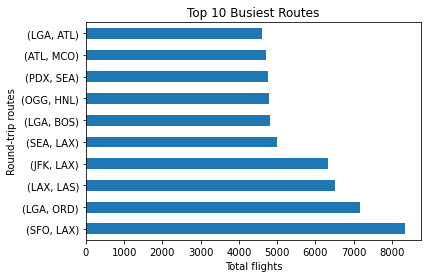

In [31]:
# get top ten busiest round trip routes
top_routes = flight_filtered['ROUND_TRIP_ROUTE'].value_counts()[:10]
top_routes.plot(kind='barh', title='Top 10 Busiest Routes')
plt.ylabel('Round-trip routes')
plt.xlabel('Total flights')

### Q2
The 10 most profitable round trip routes (without considering the upfront airplane cost) in the quarter. Along with the profit, show total revenue, total cost, summary values of other key components and total round trip flights in the quarter for the top 10 most profitable routes. Exclude canceled flights from these calculations.

In [12]:
ticket_data['ROUND_TRIP_ROUTE'] = [frozenset([x, y]) for x, y in zip(ticket_data['ORIGIN'], ticket_data['DESTINATION'])]

In [13]:
# consider only roundtrips and drop nan values
ticket_filtered = ticket_data[ticket_data['ROUNDTRIP'] == 1].dropna(subset='ITIN_FARE', axis=0)

# convert fares to numeric values
ticket_filtered['ITIN_FARE'] = pd.to_numeric(ticket_filtered['ITIN_FARE'], errors='coerce')

# exclude top and bottom 1% outliers
q_low = ticket_filtered['ITIN_FARE'].quantile(0.01)
q_hi  = ticket_filtered['ITIN_FARE'].quantile(0.99)
ticket_filtered = ticket_filtered[(ticket_filtered['ITIN_FARE'] < q_hi) & (ticket_filtered['ITIN_FARE'] > q_low)]
print(f'Filtering out ticket price above {q_hi} and below {q_low}')

Filtering out ticket price above 1656.0 and below 11.0


In [14]:
# check dataframe shape before and after cleaning
print(f'Before cleaning, ticket dataset has {ticket_data.shape[0]} records.\n'
      f'After cleaning, ticket dataset has {ticket_filtered.shape[0]} records.')

Before cleaning, ticket dataset has 1167285 records.
After cleaning, ticket dataset has 663953 records.


In [15]:
# merge fare and baggage revenues together
fare = ticket_filtered.groupby('ROUND_TRIP_ROUTE')[['ITIN_FARE']].mean()
baggage = flight_filtered.groupby('ROUND_TRIP_ROUTE')[['OCCUPANCY_RATE']].mean()
revenue = pd.merge(fare, baggage, on='ROUND_TRIP_ROUTE')
revenue.sample(5)

,ITIN_FARE,OCCUPANCY_RATE
ROUND_TRIP_ROUTE,,
"(SFO, CLT)",719.72,0.64
"(DTW, MSY)",400.33,0.65
"(LGA, BGR)",343.86,0.66
"(RNO, SJC)",229.73,0.66
"(CLE, APN)",402.00,0.68


In [16]:
# key assumptions
max_occupancy = 200
baggage_fee = 35
percentage_of_pax_checking_baggage = 0.5
maint_cost = 8 # dollars per mile
ins_cost = 1.18 # dollars per mile
airpt_cost_large = 10000
airpt_cost_medium = 5000
delay_cost = 75 # per minute over 15 minutes

In [17]:
# calculate ticket revenue per round trip
revenue['TICKET_REV'] = revenue['ITIN_FARE'] * max_occupancy * revenue['OCCUPANCY_RATE']

# calculate baggage revenue per round trip (baggage fee * number of passengers * percentage of passengers checking baggage)
revenue['BAGGAGE_REV'] = baggage_fee * 2 * max_occupancy * revenue['OCCUPANCY_RATE'] * percentage_of_pax_checking_baggage

# calculate total revenue per round trip
revenue['TOTAL_REV'] = revenue['TICKET_REV'] + revenue['BAGGAGE_REV']
revenue.sample(5)

,ITIN_FARE,OCCUPANCY_RATE,TICKET_REV,BAGGAGE_REV,TOTAL_REV
ROUND_TRIP_ROUTE,,,,,
"(MSP, SLC)",586.87,0.65,76383.54,4555.41,80938.95
"(BHM, DTW)",552.69,0.66,72497.55,4591.01,77088.55
"(SLC, BWI)",601.67,0.64,76874.01,4471.90,81345.91
"(MSP, SAT)",483.92,0.65,63018.52,4557.84,67576.37
"(ORD, OKC)",420.31,0.64,53983.87,4495.36,58479.23


In [18]:
# keep medium and large airports data only
flight_filtered = flight_filtered[flight_filtered['ORIGIN_TYPE'].isin(['medium_airport', 'large_airport'])].copy()
flight_filtered = flight_filtered[flight_filtered['DEST_TYPE'].isin(['medium_airport', 'large_airport'])].copy()

In [19]:
# column 'DISTANCE' contains mixed dtypes
pd.api.types.infer_dtype(flight_filtered['DISTANCE'])

# convert to numeric values
flight_filtered['DISTANCE'] = pd.to_numeric(flight_filtered['DISTANCE'], errors='coerce')

In [20]:
# calculate 5 costs and add up to total cost
flight_filtered['MAINT_COST'] = flight_filtered['DISTANCE'] * maint_cost
flight_filtered['INS_COST'] = flight_filtered['DISTANCE'] * ins_cost
flight_filtered['AIRPT_OP_COST'] = flight_filtered['DEST_TYPE'].apply(lambda x: airpt_cost_large if x == 'large_airport' else airpt_cost_medium)
flight_filtered['DEP_COST'] = flight_filtered['DEP_DELAY'].apply(lambda x: (x - 15) * delay_cost if x > 15 else 0)
flight_filtered['ARR_COST'] = flight_filtered['ARR_DELAY'].apply(lambda x: (x - 15) * delay_cost if x > 15 else 0)
flight_filtered['TOTAL_COST'] = flight_filtered['MAINT_COST'] + flight_filtered['INS_COST'] + flight_filtered['AIRPT_OP_COST'] + flight_filtered['DEP_COST'] + flight_filtered['ARR_COST']
flight_filtered.sample(5)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,...,OCCUPANCY_RATE,ORIGIN_TYPE,DEST_TYPE,ROUND_TRIP_ROUTE,MAINT_COST,INS_COST,AIRPT_OP_COST,DEP_COST,ARR_COST,TOTAL_COST
395586,2019-03-27,OO,N641CA,4090,12266,IAH,"Houston, TX",13487,MSP,"Minneapolis, MN",...,0.39,large_airport,large_airport,"(MSP, IAH)",8272.0,1220.12,10000,0.0,0.0,19492.12
1513124,2019-01-18,AA,N204UW,1702,14107,PHX,"Phoenix, AZ",12892,LAX,"Los Angeles, CA",...,0.63,large_airport,large_airport,"(LAX, PHX)",2960.0,436.60,10000,0.0,0.0,13396.60
1204227,2019-01-01,AX,N843HK,4614,11292,DEN,"Denver, CO",11540,ELP,"El Paso, TX",...,0.80,large_airport,medium_airport,"(ELP, DEN)",4504.0,664.34,5000,6150.0,7875.0,24193.34
1032647,2019-01-25,9E,N607LR,5243,12953,LGA,"New York, NY",13871,OMA,"Omaha, NE",...,0.91,large_airport,large_airport,"(LGA, OMA)",9184.0,1354.64,10000,3900.0,2250.0,26688.64
406271,2019-02-23,UA,N486UA,640,14908,SNA,"Santa Ana, CA",12266,IAH,"Houston, TX",...,0.68,large_airport,large_airport,"(IAH, SNA)",10768.0,1588.28,10000,0.0,0.0,22356.28


In [21]:
cost = flight_filtered.groupby('ROUND_TRIP_ROUTE')['TOTAL_COST'].agg([np.mean, 'count'])
cost.columns = ['TOTAL_COST', 'TOTAL_FLIGHTS'] # single-flight data
cost['TOTAL_COST'] = cost['TOTAL_COST'] * 2 # double for round-trip cost
cost['TOTAL_FLIGHTS'] = cost['TOTAL_FLIGHTS'] / 2 # number of round-trip flights
cost.sample(5)

,TOTAL_COST,TOTAL_FLIGHTS
ROUND_TRIP_ROUTE,,
"(CLT, DFW)",39539.21,895.0
"(SEA, IAH)",56292.52,465.5
"(BHM, DAL)",32955.67,179.0
"(SYR, FLL)",47243.43,109.0
"(ORD, CAK)",26469.74,451.5


In [22]:
# merge revenue and cost data
profit = pd.merge(revenue, cost, on='ROUND_TRIP_ROUTE')

# profit = total revenue - total cost
profit['PROFIT'] = profit['TOTAL_REV'] - profit['TOTAL_COST']

# quarterly profit = profit * number of round-trip flights
profit['QUARTERLY_PROFIT'] = profit['PROFIT'] * profit['TOTAL_FLIGHTS']

# get top profitable routes 
profit_by_quarter = profit.sort_values('QUARTERLY_PROFIT', ascending=False)
profit_by_quarter.head(10) # top routes by quarterly profit

,ITIN_FARE,OCCUPANCY_RATE,TICKET_REV,BAGGAGE_REV,TOTAL_REV,TOTAL_COST,TOTAL_FLIGHTS,PROFIT,QUARTERLY_PROFIT
ROUND_TRIP_ROUTE,,,,,,,,,
"(ORD, DCA)",532.12,0.65,68954.40,4535.45,73489.85,34686.60,1847.5,38803.25,7.17e+07
"(CLT, ATL)",508.83,0.65,66032.94,4542.13,70575.07,25910.98,1538.0,44664.09,6.87e+07
"(LGA, DCA)",479.76,0.65,62619.18,4568.28,67187.45,28055.89,1679.5,39131.56,6.57e+07
"(LGA, ATL)",456.97,0.65,59507.20,4557.77,64064.97,36959.33,2297.0,27105.64,6.23e+07
"(DCA, ATL)",467.18,0.65,60773.29,4552.99,65326.28,32180.85,1744.0,33145.43,5.78e+07


In [23]:
profit_by_trip = profit.sort_values('PROFIT', ascending=False)
profit_by_trip.head(10) # top routes by individual profit

,ITIN_FARE,OCCUPANCY_RATE,TICKET_REV,BAGGAGE_REV,TOTAL_REV,TOTAL_COST,TOTAL_FLIGHTS,PROFIT,QUARTERLY_PROFIT
ROUND_TRIP_ROUTE,,,,,,,,,
"(ADK, ANC)",1126.60,0.66,148809.17,4623.04,153432.21,38316.64,23.0,115115.57,2.65e+06
"(MDT, PHL)",909.00,0.65,117998.27,4543.39,122541.66,18535.19,397.0,104006.48,4.13e+07
"(IAH, STT)",838.27,0.88,147534.93,6160.00,153694.93,53005.20,1.0,100689.73,1.01e+05
"(DEN, SUN)",805.75,0.66,105873.34,4598.90,110472.25,26315.22,73.0,84157.03,6.14e+06
"(GUM, HNL)",1343.62,0.62,167200.41,4355.42,171555.83,90292.29,88.5,81263.54,7.19e+06


### Q3
The 5 round trip routes that you recommend to invest in based on any factors that you
choose.

In [24]:
# get on-time flights
delay = flight_filtered.groupby('ROUND_TRIP_ROUTE')[['ARR_DELAY']].mean()
on_time_flights = delay[delay['ARR_DELAY'] <= 15]
on_time_flights.head()

,ARR_DELAY
ROUND_TRIP_ROUTE,
"(CLE, RSW)",5.23
"(CID, CLT)",2.81
"(CLT, MSN)",4.59
"(CHA, CLT)",3.51
"(CLT, SAV)",2.28


In [25]:
# choose routes that are both profitable at individual & quarter level and on time
rec_routes = []
for route in profit_by_trip.index:
    if route in profit_by_quarter.index[:50] and route in on_time_flights.index:
        rec_routes.append(route)
        if len(rec_routes) == 5:
            break
rec_routes

[frozenset({'MDT', 'PHL'}),
 frozenset({'ORD', 'XNA'}),
 frozenset({'CLT', 'GSP'}),
 frozenset({'CLT', 'MYR'}),
 frozenset({'CLT', 'GSO'})]

### Q4
The number of round trip flights it will take to breakeven on the upfront airplane cost for each of the 5 round trip routes that you recommend. Print key summary components for these routes.

In [26]:
# breakeven analysis
breakeven = profit_by_trip.loc[rec_routes]
breakeven

,ITIN_FARE,OCCUPANCY_RATE,TICKET_REV,BAGGAGE_REV,TOTAL_REV,TOTAL_COST,TOTAL_FLIGHTS,PROFIT,QUARTERLY_PROFIT
ROUND_TRIP_ROUTE,,,,,,,,,
"(MDT, PHL)",909.00,0.65,117998.27,4543.39,122541.66,18535.19,397.0,104006.48,4.13e+07
"(ORD, XNA)",759.45,0.65,98488.04,4538.93,103026.97,27869.23,531.0,75157.74,3.99e+07
"(CLT, GSP)",718.33,0.65,93322.97,4547.06,97870.03,23377.03,773.5,74493.00,5.76e+07
"(CLT, MYR)",660.67,0.65,85427.03,4525.65,89952.68,19303.31,677.0,70649.37,4.78e+07
"(GSO, CLT)",686.00,0.65,89322.09,4557.25,93879.34,23326.40,743.5,70552.94,5.25e+07


In [36]:
upfront_cost = 90_000_000
breakeven['ROUND_TRIPS_TO_BREAKEVEN'] = (upfront_cost / breakeven['PROFIT']).astype(int)
breakeven[['PROFIT', 'QUARTERLY_PROFIT', 'ROUND_TRIPS_TO_BREAKEVEN']]

,PROFIT,QUARTERLY_PROFIT,ROUND_TRIPS_TO_BREAKEVEN
ROUND_TRIP_ROUTE,,,
"(MDT, PHL)",104006.48,4.13e+07,865
"(ORD, XNA)",75157.74,3.99e+07,1197
"(CLT, GSP)",74493.00,5.76e+07,1208
"(CLT, MYR)",70649.37,4.78e+07,1273
"(GSO, CLT)",70552.94,5.25e+07,1275


### Q5
Key Performance Indicators (KPI's) that you recommend tracking in the future to measure the success of the round trip routes that you recommend.

- Departure/arrival punctuality: the percentage of flights that depart/arrive on-time at the planned origin/destination airport. All flights that depart/arrive as scheduled or with a 15-minute window are considered on-time.
- Seat load factor: the percentage of checked-in passengers in relation to an aircraft’s available seats. Seat load factor is an important measure of profitability.
- Completion factor: the percentage of scheduled flights that are completed and not cancelled over a defined period. Cancellations will adversely affect profitability and brand image.